In [1]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt


class DofManager():
    def __init__(self,element_df,node_df):
        self.element_df = element_df
        self.node_df = node_df
        self.tag = 'phys_group'
    
    def get_dof_from_node(self,node_id):
        node_df = self.node_df
        return list(node_df.iloc[node_id])
        
    def get_connectivity_from_elem_id(self,elem_id): 
        element_df = self.element_df
        return list(element_df['connectivity'].iloc[elem_id])
    
    def get_dof_list_from_elem_id(self,elem_id):
        return list(map(self.get_dof_from_node,self.get_connectivity_from_elem_id(elem_id)))
    
    def get_elements_from_group_id(self,group_id):
        element_df = self.element_df
        tag = self.tag
        return list(element_df.loc[element_df[tag] == group_id].index)
    
    def get_dof_list_from_group_id(self,group_id): 
        return np.sort(np.array(list(map(self.get_dof_list_from_elem_id,self.get_elements_from_group_id(group_id)))).flatten())
    
    def get_node_list_from_group_id(self,group_id):
        node_list = []
        for elem_id in self.get_elements_from_group_id(group_id): 
            node_list.extend(self.get_connectivity_from_elem_id(elem_id))
        return np.sort(node_list)

Could not load paradiso!
Could not load paradiso!
Warning! Using python in global path


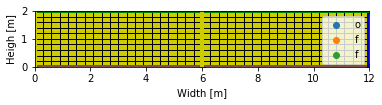

In [2]:
width = 6
heigh = 2
dobj = DomainCreator(width=width,heigh=heigh,x_divisions=21,y_divisions=11)
mesh_file = 'mesh.msh'
dobj.save_gmsh_file(mesh_file)

m1 = amfe.Mesh()
m1.import_msh(mesh_file)

m2 = m1.translation(np.array([6.,0.]))

ax1 = amfe.plot2Dmesh(m1)
amfe.plot2Dmesh(m2,ax=ax1)

ax1.set_xlim([0,2*width])
ax1.set_ylim([0,heigh])
ax1.set_aspect('equal')
ax1.set_xlabel('Width [m]')
ax1.set_ylabel('Heigh [m]')
plt.legend('off')

# Solving Static Problem

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{f}  \\
\mathbf{0}   
\end{bmatrix}
$$

In [3]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210.0E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system1 = amfe.MechanicalSystem()
my_system1.set_mesh_obj(m1)
my_system1.set_domain(3,my_material)

K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()


my_system2 = amfe.MechanicalSystem()
my_system2.set_mesh_obj(m2)
my_system2.set_domain(3,my_material)

K2, _ = my_system2.assembly_class.assemble_k_and_f()
M2 = my_system2.assembly_class.assemble_m()

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 200 elements and 462 dofs.
Time taken for preallocation: 0.01 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 200 elements and 462 dofs.
Time taken for preallocation: 0.00 seconds.


In [4]:
try:
    connectivity = []
    for _,item in m1.el_df.iloc[:, m1.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m1.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m1.el_df)

neighbors_dict = {}
neighbors_dict['right'] = 2
neighbors_dict['left'] = 1
neighbors_dict['top'] = 5
neighbors_dict['bottom'] = 4
neighbors_dict['bottom_left_corner'] = 6
neighbors_dict['bottom_right_corner'] = 7
neighbors_dict['top_left_corner'] = 8
neighbors_dict['top_right_corner'] = 9

B_local_dict = {}
for key, value in neighbors_dict.items():
    B_local_dict[key] = s.build_B(value)

In [5]:
zeros = np.zeros(K1.shape[0])
case = FETIcase_builder(2,1, K1, zeros, B_local_dict,s,BC_type='G',force_scaling=1.0)
K_dict, B_dict, f_dict = case.build_subdomain_matrices()

In [6]:
feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-6)
solution_obj = feti_obj.solve()
u_dict = solution_obj.u_dict

p0 = 0.5
u1=p0*u_dict[1]
u2=p0*u_dict[2]
my_system1.u_output = [u1]
my_system2.u_output = [u2]

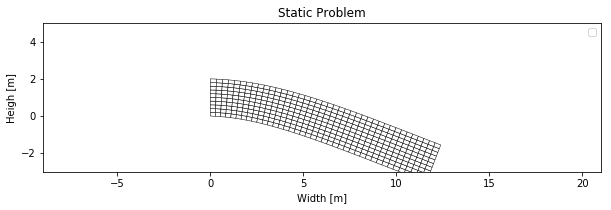

In [7]:
fig, ax2 = plt.subplots(1,1,figsize=(10,3))
amfe.plot_2D_system_solution(my_system1,u_id=0,ax=ax2)
amfe.plot_2D_system_solution(my_system2,u_id=0,ax=ax2)
delta_ = 1.5
ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
ax2.set_aspect('equal')
ax2.set_xlabel('Width [m]')
ax2.set_ylabel('Heigh [m]')
plt.title('Static Problem')
plt.legend('off')

# Solving Hybrid Eigen-problem

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
=
\omega^2
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
$$

In [8]:
M_dict = {1:M1, 2:M2}
#K_dict = {1:K1, 2:K2}
manager = SolverManager(K_dict,B_dict,f_dict,tolerance=1.0e-12)
managerM = SolverManager(M_dict,B_dict,f_dict,tolerance=1.0e-12)
M1 = managerM.local_problem_dict[1].K_local
M1.key_dict = s.selection_dict
M1.eliminate_by_identity(1,multiplier=0.0)
M_dict = {1:M1, 2:M2}

In [9]:
B = manager.assemble_global_B().A

M_,_ = managerM.assemble_global_K_and_f()
K, _ = manager.assemble_global_K_and_f()
M = M_.A
BBT_inv = np.linalg.inv(B.dot(B.T))
P = np.eye(M.shape[0]) + B.T.dot(BBT_inv.dot(B))
u0 = solution_obj.displacement 

# Solving Hybrid Eigen-problem using the Primal Assembly Operator

$$
\begin{bmatrix}
\mathbf{L}^T \mathbf{K} \mathbf{L}^T 
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\end{bmatrix}
=
\omega^2
\begin{bmatrix}
\mathbf{L}^T \mathbf{M} \mathbf{L} 
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\end{bmatrix}
$$

In [10]:
L = manager.assemble_global_L()
Lexp = manager.assemble_global_L_exp()

Kp = L.dot(K.dot(Lexp))
Mp = L.dot(M.dot(Lexp))
Dp = np.linalg.inv(Kp).dot(Mp)

eigval_, Vp = sparse.linalg.eigsh(Dp,k=20,v0=L.dot(u0))
eigval_

val_p = np.sort(1/eigval_)
val_p

freq_p = np.sqrt(val_p)/(2.0*np.pi)
freq_p

array([  11.43136274,   64.88114076,  107.91325234,  160.36643273,
        271.50131686,  323.26813154,  399.86235516,  525.76567626,
        536.77332776,  651.21601097,  745.47719729,  782.42380138,
        844.04865774,  886.97587616,  940.38726376,  962.02892902,
       1007.02093478, 1098.9024146 , 1105.08406499, 1143.07358405])

Text(0.5, 1.0, 'Frequency [Hz]')

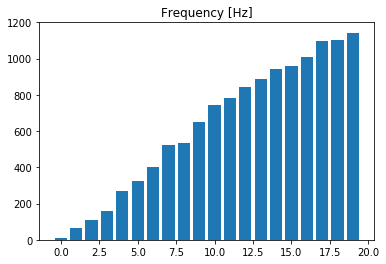

In [11]:
plt.bar(list(range(len(freq_p))),freq_p)
plt.title('Frequency [Hz]')

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial random guess

In [12]:
def system_without_projection(u,tol=1.0e-6):
    
    f = M.dot(u)
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    return solution_obj.displacement
    
un = system_without_projection(u0)
D_wp = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system_without_projection(x))

In [13]:
eigval_without_projection_, V_wp_ = sparse.linalg.eigsh(D_wp,k=20)
val_wp_ = np.sort(1/eigval_without_projection_)
freq_dual_wp_ = np.sqrt(val_wp_)/(2.0*np.pi)
freq_dual_wp_

/home/ge72tih/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


array([          nan,   11.4323398 ,   64.5417571 ,  108.64025606,
        158.80894667,  270.40434657,  323.23601033,  393.0294496 ,
        523.98946035,  535.779191  ,  658.58586556,  747.66954587,
        777.22846585,  846.20084335,  883.22991996,  944.86458363,
        961.56397034, 1005.80558696, 1101.10075254, 1105.64332615])

Text(0.5, 1.0, 'Frequency [Hz]')

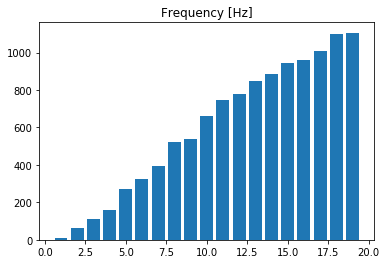

In [14]:
plt.bar(list(range(len(freq_dual_wp_))),freq_dual_wp_)
plt.title('Frequency [Hz]')

Text(0, 0.5, 'Frequency Dual without projection with initial random guess')

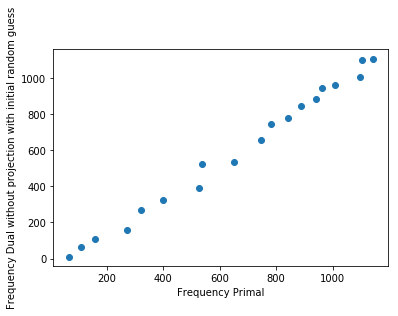

In [15]:
plt.plot(freq_p,freq_dual_wp_,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual without projection with initial random guess')

In [16]:
v_dict = manager.vector2localdict(V_wp_,manager.global2local_primal_dofs)
p0 = 10.0
u1=p0*v_dict[1]
u2=p0*v_dict[2]
my_system1.u_output = list(u1.T)
my_system2.u_output = list(u2.T)

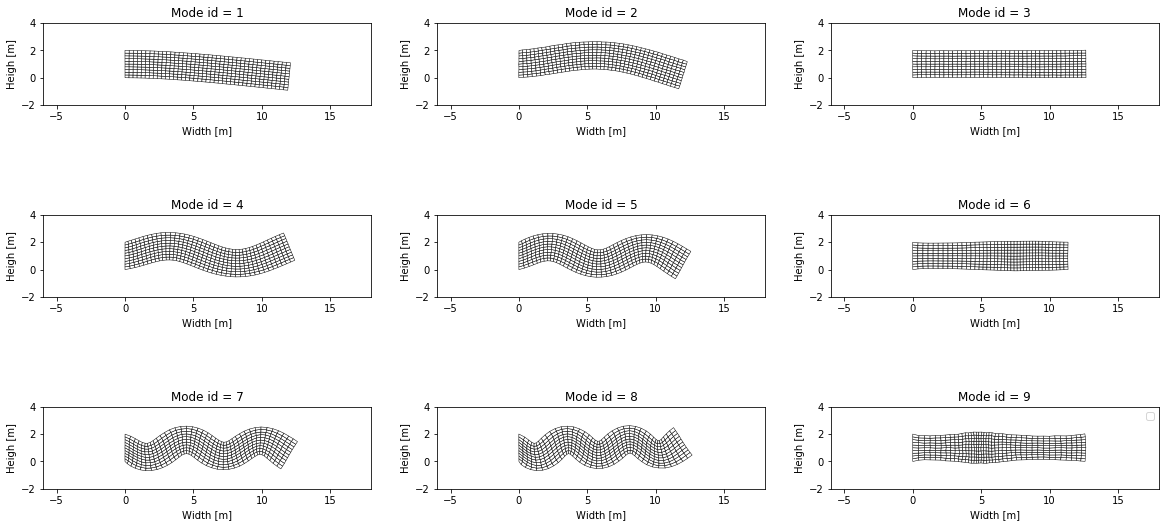

In [17]:
fig, ax1_list = plt.subplots(3,3,figsize=(20,10))
counter = 0
delta_ = 1.0
for ax_ij in ax1_list:
    for ax2 in ax_ij:
        amfe.plot_2D_system_solution(my_system1,u_id=(19 - counter),ax=ax2)
        amfe.plot_2D_system_solution(my_system2,u_id=(19 - counter),ax=ax2)
        ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial guess $v_0 = P v$

In [18]:
eigval_without_projection, V_wp = sparse.linalg.eigsh(D_wp,k=20,v0 = P.dot(u0))
val_wp = np.sort(1/eigval_without_projection)
freq_dual_wp = np.sqrt(val_wp)/(2.0*np.pi)
freq_dual_wp

array([  11.43336641,   64.49858854,  107.91232872,  160.66246718,
        270.95677195,  323.28013166,  401.2345156 ,  525.44178828,
        536.80616702,  653.04930347,  745.45927405,  781.7481208 ,
        843.03537079,  888.01987902,  940.66729639,  962.99821549,
       1007.31341946, 1098.95255351, 1104.21378596, 1143.5069223 ])

Text(0.5, 1.0, 'Frequency [Hz]')

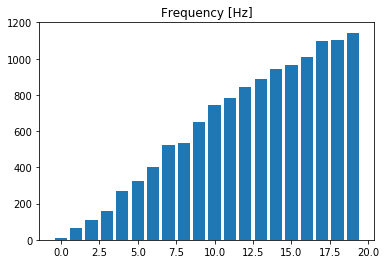

In [19]:
plt.bar(list(range(len(freq_dual_wp))),freq_dual_wp)
plt.title('Frequency [Hz]')

Text(0, 0.5, 'Frequency Dual without projection')

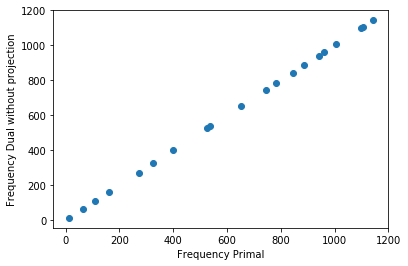

In [20]:
plt.plot(freq_p,freq_dual_wp,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual without projection')

In [21]:
v_dict = manager.vector2localdict(V_wp,manager.global2local_primal_dofs)
p0 = 10.0
u1=p0*v_dict[1]
u2=p0*v_dict[2]
my_system1.u_output = list(u1.T)
my_system2.u_output = list(u2.T)

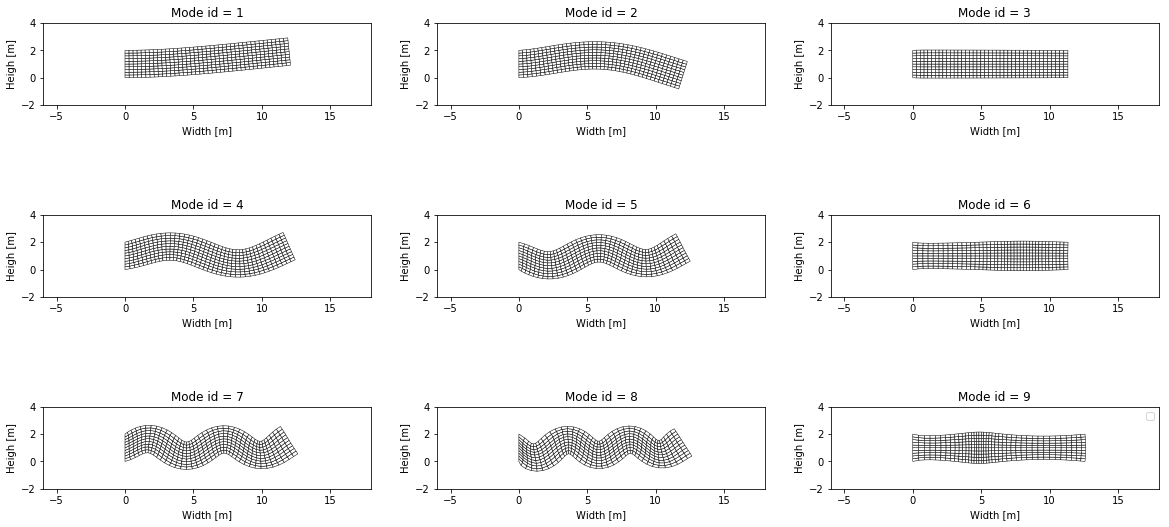

In [22]:
fig, ax1_list = plt.subplots(3,3,figsize=(20,10))
counter = 0
delta_ = 1.0
for ax_ij in ax1_list:
    for ax2 in ax_ij:
        amfe.plot_2D_system_solution(my_system1,u_id=(19 - counter),ax=ax2)
        amfe.plot_2D_system_solution(my_system2,u_id=(19 - counter),ax=ax2)
        ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{P}^T \mathbf{M}\mathbf{P} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial guess $v_0 = P v$

In [23]:
u0 = solution_obj.displacement 
def system(u,tol=1.0e-6):
    f = P.T.dot(M.dot(P.dot(u)))
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    return solution_obj.displacement
    
un = system(u0)

In [24]:
D = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system(x))
eigval, V = sparse.linalg.eigsh(D,k=20,v0 = P.dot(u0))
val = np.sort(1/eigval)
freq_dual = np.sqrt(val)/(2.0*np.pi)
freq_dual

array([  11.43336641,   64.49858855,  107.91315699,  160.66246803,
        270.95676129,  323.27587788,  401.23450058,  525.43949812,
        536.82895503,  653.00470585,  745.36007763,  781.72305153,
        843.01433316,  887.96712459,  940.62358253,  962.94028976,
       1007.26103079, 1099.07722148, 1104.2731779 , 1143.60203513])

Text(0.5, 1.0, 'Frequency [Hz]')

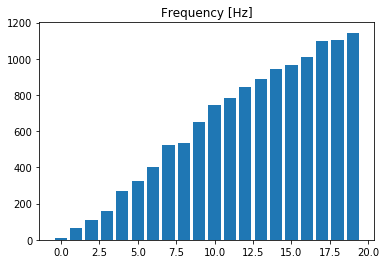

In [25]:
plt.bar(list(range(len(freq_dual))),freq_dual)
plt.title('Frequency [Hz]')

Text(0, 0.5, 'Frequency Dual with Projection')

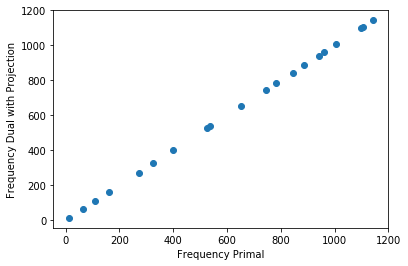

In [26]:
plt.plot(freq_p,freq_dual,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual with Projection')

In [27]:
v_dict = manager.vector2localdict(V,manager.global2local_primal_dofs)
p0 = 10.0
u1=p0*v_dict[1]
u2=p0*v_dict[2]
my_system1.u_output = list(u1.T)
my_system2.u_output = list(u2.T)

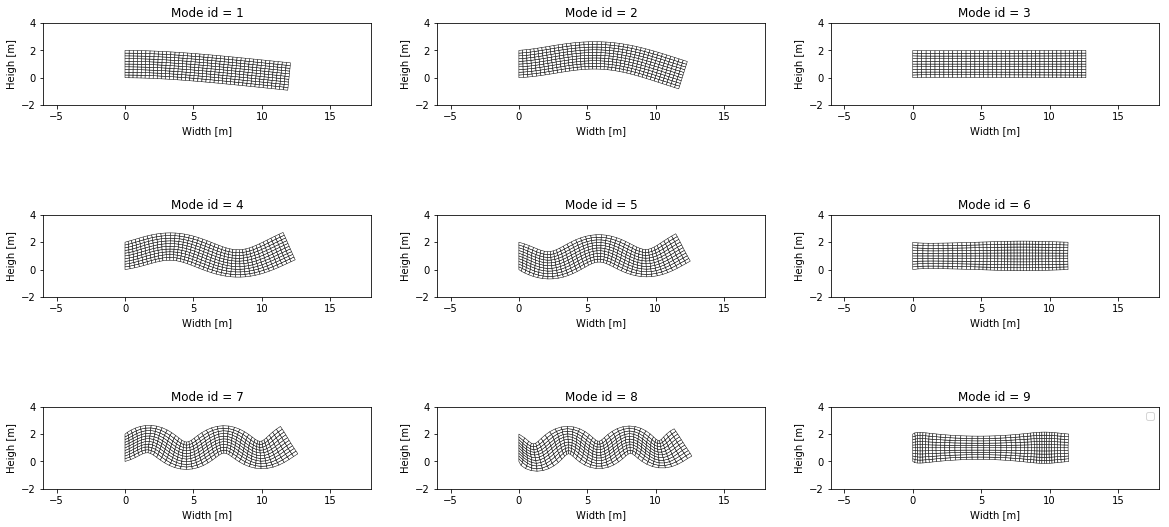

In [28]:
fig, ax3_list = plt.subplots(3,3,figsize=(20,10))
counter = 0
delta_ = 1.0
for ax_ij in ax3_list:
    for ax2 in ax_ij:
        amfe.plot_2D_system_solution(my_system1,u_id=(19 - counter),ax=ax2)
        amfe.plot_2D_system_solution(my_system2,u_id=(19 - counter),ax=ax2)
        ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')

# Total FETI approach

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B}_{total}^T  \\
\mathbf{B}_{total} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{P}_{total}^T \mathbf{M}\mathbf{P}_{total} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

In [29]:
K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()


my_system2 = amfe.MechanicalSystem()
my_system2.set_mesh_obj(m2)
my_system2.set_domain(3,my_material)

K2, _ = my_system2.assembly_class.assemble_k_and_f()
M2 = my_system2.assembly_class.assemble_m()

K_dict_ = {1:K1, 2:K2}
B_dict_total = B_dict.copy()

B_dict_total[1].update( {(1,1): s.build_B(1)}) # add Dirichlet Constraint
M_dict = {1:M1, 2:M2}

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 400 elements and 462 dofs.
Time taken for preallocation: 0.01 seconds.


In [30]:
B_dict_total

{1: {(1, 2): <22x462 sparse matrix of type '<class 'numpy.int8'>'
  	with 22 stored elements in Compressed Sparse Row format>,
  (1, 1): <22x462 sparse matrix of type '<class 'numpy.int8'>'
  	with 22 stored elements in Compressed Sparse Row format>},
 2: {(2, 1): <22x462 sparse matrix of type '<class 'numpy.int8'>'
  	with 22 stored elements in Compressed Sparse Row format>}}

In [31]:
managerT = SolverManager(K_dict_,B_dict_total,f_dict,tolerance=1.0e-12)
B_ = managerT.assemble_global_B().A

BBT_inv_ = np.linalg.inv(B_.dot(B_.T))
P_ = np.eye(M.shape[0]) + B_.T.dot(BBT_inv_.dot(B_))
#P = np.eye(M.shape[0])

def systemT(u,tol=1.0e-6):
    f_ = P_.T.dot(M.dot(P_.dot(u)))
    f_dict_ = manager.vector2localdict(f_,managerT.global2local_primal_dofs)
    feti_obj_ = SerialFETIsolver(K_dict_,B_dict_total,f_dict_,tolerance=tol)
    solution_obj_ = feti_obj_.solve()
    u_dict_ = solution_obj_.u_dict
    return solution_obj_.displacement
    
un = system(u0)

In [32]:
DT = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : systemT(x))

eigvalT, VT = sparse.linalg.eigsh(DT,k=20,v0 = P_.dot(u0))
val_T = np.sort(1/eigvalT)
freq_T = np.sqrt(val_T)/(2.0*np.pi)

In [33]:
v_dict = manager.vector2localdict(V,managerT.global2local_primal_dofs)
p0 = 10.0
u1=p0*v_dict[1]
u2=p0*v_dict[2]
my_system1.u_output = list(u1.T)
my_system2.u_output = list(u2.T)

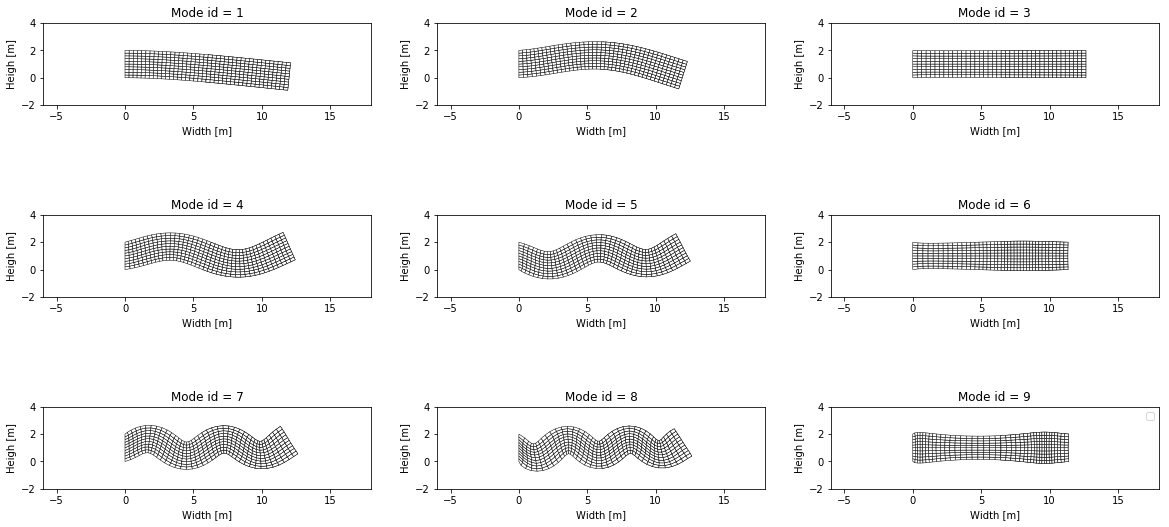

In [34]:
fig, ax4_list = plt.subplots(3,3,figsize=(20,10))
counter = 0
delta_ = 1.0
for ax_ij in ax4_list:
    for ax2 in ax_ij:
        amfe.plot_2D_system_solution(my_system1,u_id=(19 - counter),ax=ax2)
        amfe.plot_2D_system_solution(my_system2,u_id=(19 - counter),ax=ax2)
        ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')